# Anomaly Visualization Notebook

This notebook visualizes the anomalies in the smart meter data using the Isolation Forest method as well as displays predictions from other supervised models (LightGBM and a Neural Network). It includes:

- Isolation Forest anomaly visualization on a selected time window
- Distribution of anomaly scores
- Scatter plot of anomaly scores vs. energy consumption
- Optional supervised model prediction visualizations (LGBM and NN predictions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import sys
%matplotlib inline

## Configuration and Data Loading

The following cell sets up file paths and loads the data. It also ensures that the `DateTime` column is parsed and the data is sorted by time.

In [2]:
# --- Configuration ---
data_path = '../data/processed/smart_meter_data_anomalies_if.csv'
if_model_path = "../models/isolation_forest_model.pkl"
# Add paths for other models if you want to visualize their predictions
lgbm_model_path = "../models/lightgbm_model.pkl"
nn_model_path = "../models/nn_model.h5"
nn_scaler_path = "../models/nn_scaler.pkl"

print(f"Attempting to load data from: {data_path}")
try:
    # You may uncomment the nrows parameter for a smaller sample if needed
    # data = pd.read_csv(data_path, nrows=500000)
    data = pd.read_csv(data_path)
    print("Data loaded successfully.")
    # Ensure DateTime is parsed and sorted
    if 'DateTime' in data.columns:
        data['DateTime'] = pd.to_datetime(data['DateTime'])
        data.sort_values('DateTime', inplace=True)
    else:
        print("Warning: DateTime column not found.")
except FileNotFoundError:
    print(f"Error: Data file not found at {data_path}.")
    exit()
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

Attempting to load data from: ../data/processed/smart_meter_data_anomalies_if.csv
Data loaded successfully.


## Visualizing Isolation Forest Anomalies

This cell selects a shorter time window from the data (e.g., a 30-day period starting 90 days into the dataset) and then plots the overall energy consumption alongside the anomalies detected by Isolation Forest.


Visualizing Isolation Forest Anomalies...


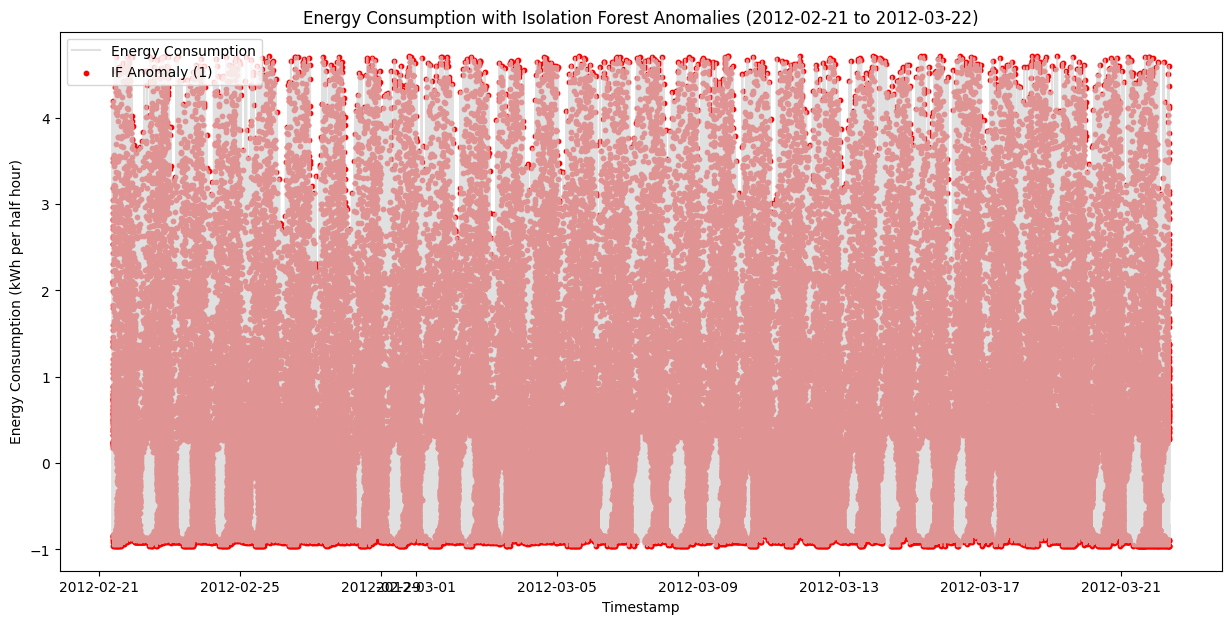

In [3]:
if 'anomaly' in data.columns and 'DateTime' in data.columns and 'KWH/hh (per half hour)' in data.columns:
    print("\nVisualizing Isolation Forest Anomalies...")
    
    # Select a shorter time window for clarity (e.g., one month)
    start_date = data['DateTime'].min() + pd.Timedelta(days=90)  # Example: Start 90 days in
    end_date = start_date + pd.Timedelta(days=30)  # Plot 30 days
    mask = (data['DateTime'] >= start_date) & (data['DateTime'] <= end_date)
    subset = data.loc[mask]

    if not subset.empty:
        plt.figure(figsize=(15, 7))
        # Plot overall energy consumption for the subset
        plt.plot(subset['DateTime'], subset['KWH/hh (per half hour)'], color='lightgray', 
                 label='Energy Consumption', alpha=0.7)
        
        # Highlight anomalies detected by Isolation Forest
        anomalies_subset = subset[subset['anomaly'] == 1]
        plt.scatter(anomalies_subset['DateTime'], anomalies_subset['KWH/hh (per half hour)'],
                    color='red', label='IF Anomaly (1)', marker='o', s=10)  # Smaller markers
        
        plt.xlabel('Timestamp')
        plt.ylabel('Energy Consumption (kWh per half hour)')
        plt.title(f'Energy Consumption with Isolation Forest Anomalies ({start_date.date()} to {end_date.date()})')
        plt.legend()
        plt.show()
    else:
        print("No data found in the selected time window for anomaly visualization.")
elif 'anomaly' not in data.columns:
    print("Column 'anomaly' not found. Cannot visualize anomalies.")
else:
    print("Required columns ('DateTime', 'KWH/hh (per half hour)') not found for anomaly time series plot.")

## Visualizing Anomaly Scores

This cell shows the distribution of anomaly scores computed by the Isolation Forest method, along with a scatter plot of anomaly score vs. energy consumption.


Visualizing Anomaly Score Distribution...


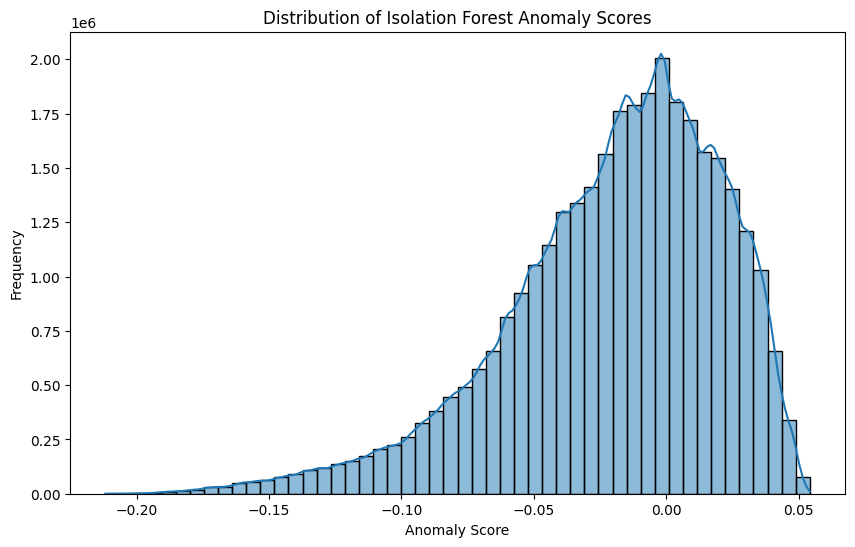

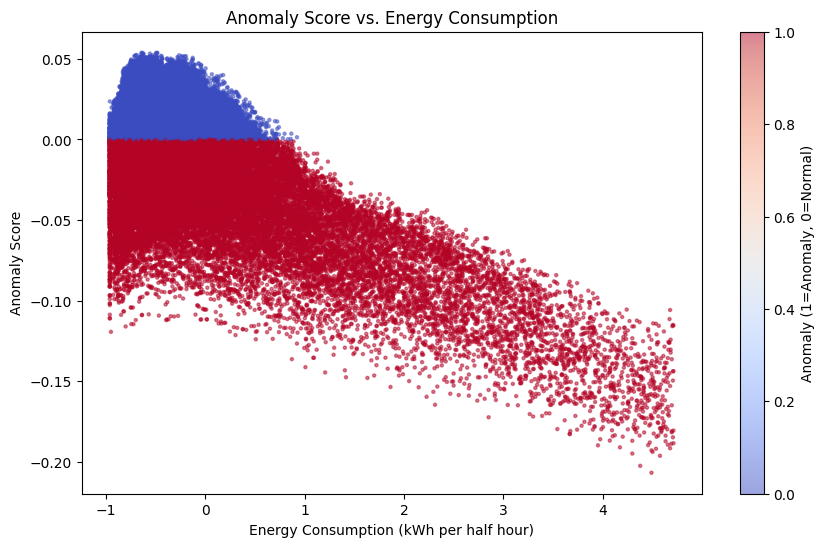

In [4]:
if 'anomaly_score' in data.columns:
    print("\nVisualizing Anomaly Score Distribution...")
    plt.figure(figsize=(10, 6))
    sns.histplot(data['anomaly_score'], bins=50, kde=True)
    plt.title('Distribution of Isolation Forest Anomaly Scores')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.show()
    
    # Scatter plot of score vs consumption (use sample to avoid overplotting)
    if 'KWH/hh (per half hour)' in data.columns:
         plt.figure(figsize=(10, 6))
         sample_df = data.sample(n=min(50000, len(data)), random_state=42)
         plt.scatter(sample_df['KWH/hh (per half hour)'], sample_df['anomaly_score'],
                     c=sample_df['anomaly'], cmap='coolwarm', alpha=0.5, s=5)
         plt.xlabel('Energy Consumption (kWh per half hour)')
         plt.ylabel('Anomaly Score')
         plt.title('Anomaly Score vs. Energy Consumption')
         plt.colorbar(label='Anomaly (1=Anomaly, 0=Normal)')
         plt.show()
else:
    print("Column 'anomaly_score' not found.")

## Visualizing Supervised Model Predictions

The following section demonstrates how to visualize predictions from supervised models. We first define the features to use (excluding certain columns) and then attempt to load models to predict on the data.

### LightGBM Prediction Visualization
A crosstab of Isolation Forest anomaly labels versus LightGBM predictions is displayed.

Initial features based on numeric columns: ['KWH/hh (per half hour)', 'hour', 'day_of_week', 'month', 'anomaly_score', 'anomaly', 'lgbm_prediction']
Adjusted features for prediction: ['KWH/hh (per half hour)', 'hour', 'day_of_week', 'month']

Visualizing LGBM Predictions (Example)...

Comparison of IF Anomaly vs LGBM Prediction (Counts):
LGBM Prediction         0         1
IF Anomaly                         
0                11356374    351938
1                  308288  20997323


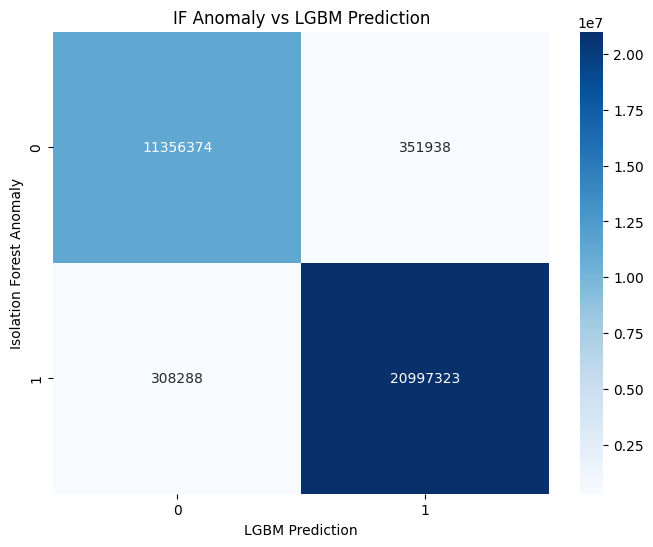

In [9]:
# Define features consistently (should match training)
numeric_features = data.select_dtypes(include=np.number).columns.tolist()
# Exclude columns that aren't features, including "lgbm_prediction" if it exists.
features_to_exclude = ['cluster', 'anomaly_score', 'anomaly', 'LCLid', 'lgbm_prediction']
features = [col for col in numeric_features if col not in features_to_exclude]

print("Initial features based on numeric columns:", numeric_features)
print("Adjusted features for prediction:", features)

if features:
    print("\nVisualizing LGBM Predictions (Example)...")
    if os.path.exists(lgbm_model_path):
        try:
            lgbm_model = joblib.load(lgbm_model_path)
            
            # Optionally, you can force LightGBM to ignore shape check, but it's better to match expected features.
            data['lgbm_prediction'] = lgbm_model.predict(data[features])
            
            # Compute a crosstab of Isolation Forest anomaly vs LGBM predictions
            crosstab = pd.crosstab(data['anomaly'], data['lgbm_prediction'],
                                   rownames=['IF Anomaly'], colnames=['LGBM Prediction'])
            print("\nComparison of IF Anomaly vs LGBM Prediction (Counts):")
            print(crosstab)
            
            # Plot the crosstab as a heatmap
            plt.figure(figsize=(8, 6))
            sns.heatmap(crosstab, annot=True, fmt="d", cmap="Blues")
            plt.title("IF Anomaly vs LGBM Prediction")
            plt.xlabel("LGBM Prediction")
            plt.ylabel("Isolation Forest Anomaly")
            plt.show()
            
        except Exception as e:
            print(f"Error loading or predicting with LGBM model: {e}")
    else:
         print(f"LGBM model not found at {lgbm_model_path}, skipping visualization.")
else:
    print("Could not determine features for supervised model prediction visualization.")


### Neural Network Prediction Visualization

This cell loads the Neural Network model and its scaler, scales the features, and then predicts probabilities. A crosstab comparing Isolation Forest anomaly labels with NN predictions is displayed. Additionally, if a time subset exists, prediction disagreements are highlighted.


Visualizing Neural Network Predictions...


2025-04-10 14:04:36.367028: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 14:04:36.370282: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 14:04:36.379480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744308276.394758   63974 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744308276.405587   63974 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744308276.416666   63974 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

NN model and scaler loaded.


/home/biswas.is/ondemand/data/sys/dashboard/batch_connect/sys/vscode/ML.Final.Project/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1031686/1031686 ━━━━━━━━━━━━━━━━━━━━ 432s 419us/step

Comparison of IF Anomaly vs NN Prediction (Counts):
NN Prediction         0         1
IF Anomaly                       
0              11695786     12526
1               2888471  18417140
 197/6234 ━━━━━━━━━━━━━━━━━━━━ 3s 513us/step

/home/biswas.is/ondemand/data/sys/dashboard/batch_connect/sys/vscode/ML.Final.Project/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


6234/6234 ━━━━━━━━━━━━━━━━━━━━ 3s 416us/step


/tmp/ipykernel_63974/1758761584.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['nn_prediction'] = (nn_model.predict(subset_scaled) > threshold).astype(int)


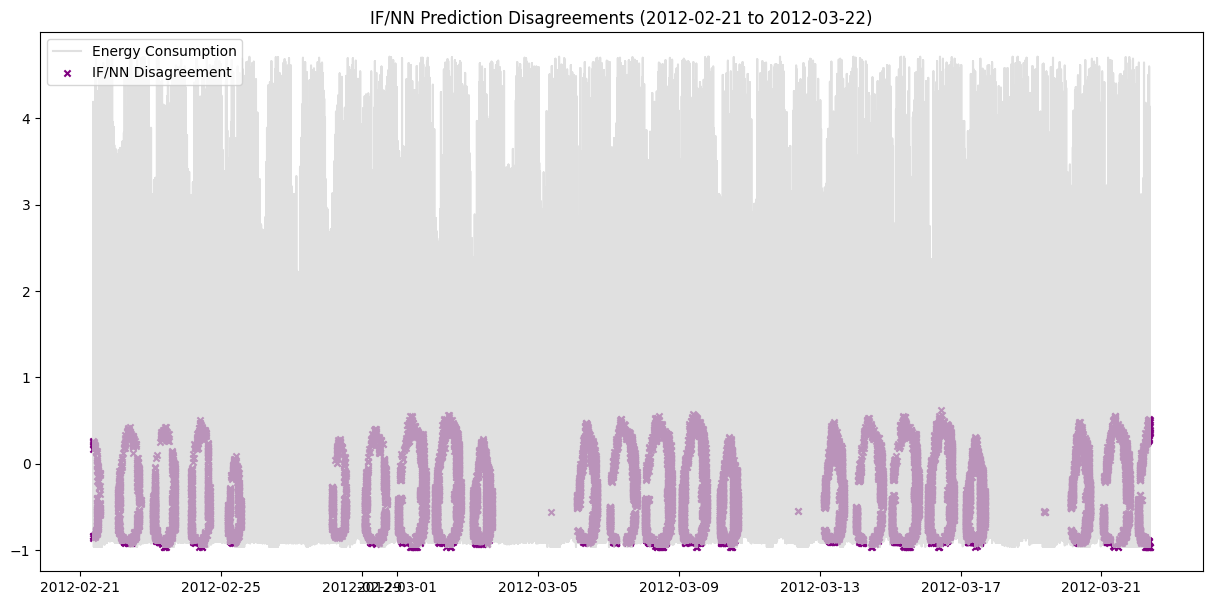

In [10]:
print("\nVisualizing Neural Network Predictions...")
if os.path.exists(nn_model_path) and os.path.exists(nn_scaler_path):
    try:
        import tensorflow as tf
        from sklearn.preprocessing import StandardScaler
        nn_model = tf.keras.models.load_model(nn_model_path)
        scaler = joblib.load(nn_scaler_path)
        print("NN model and scaler loaded.")

        # Scale features for prediction
        X_scaled = scaler.transform(data[features])
        nn_probabilities = nn_model.predict(X_scaled)
        threshold = 0.5
        data['nn_prediction'] = (nn_probabilities > threshold).astype(int)

        print("\nComparison of IF Anomaly vs NN Prediction (Counts):")
        print(pd.crosstab(data['anomaly'], data['nn_prediction'], rownames=['IF Anomaly'], colnames=['NN Prediction']))

        # Optional: If a time subset was defined in the Isolation Forest section, visualize disagreements
        if 'subset' in locals() and not subset.empty:
             try:
                 subset_scaled = scaler.transform(subset[features])
                 subset['nn_prediction'] = (nn_model.predict(subset_scaled) > threshold).astype(int)
                 mismatches = subset[subset['anomaly'] != subset['nn_prediction']]
                 if not mismatches.empty:
                     plt.figure(figsize=(15, 7))
                     plt.plot(subset['DateTime'], subset['KWH/hh (per half hour)'], 
                              color='lightgray', label='Energy Consumption', alpha=0.7)
                     plt.scatter(mismatches['DateTime'], mismatches['KWH/hh (per half hour)'],
                                 color='purple', label='IF/NN Disagreement', marker='x', s=20)
                     plt.title(f'IF/NN Prediction Disagreements ({subset["DateTime"].min().date()} to {subset["DateTime"].max().date()})')
                     plt.legend()
                     plt.show()
                 else:
                     print("No disagreements found between IF and NN predictions in the subset.")
             except Exception as e:
                 print(f"Error during NN prediction visualization on subset: {e}")
    except Exception as e:
        print(f"Error loading or predicting with NN model: {e}")
else:
    if not os.path.exists(nn_model_path):
        print(f"NN model file not found at {nn_model_path}, skipping visualization.")
    if not os.path.exists(nn_scaler_path):
        print(f"NN scaler file not found at {nn_scaler_path}, skipping visualization.")

## Conclusion

The anomaly visualization notebook has now demonstrated several key visualizations, including isolation forest anomalies, anomaly score distributions, and supervised model prediction comparisons.

In [11]:
print("\nAnomaly visualization script finished.")


Anomaly visualization script finished.
